In [ ]:
#  Imports
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from collections import OrderedDict

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset


from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

import requests
from tqdm.auto import tqdm

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1.Load and explore the data

In [ ]:
fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

urls =['https://osf.io/r638s/download',
       'https://osf.io/yqb3e/download',
       'https://osf.io/ymnjv/download']

for i, url in enumerate(urls):
  r = requests.get(url, allow_redirects=True)
  with open(fnames[i], 'wb') as fh:
    fh.write(r.content)


with np.load(fnames[2]) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

In [ ]:
print(labels[0])

['artifact' 'entity' 'animal' ... 'artifact' 'artifact' 'artifact']


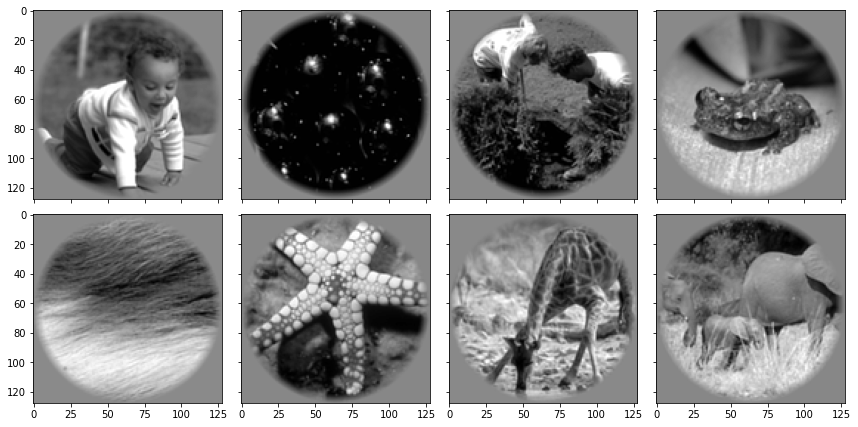

In [ ]:
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im in zip(axs.flat, dat["stimuli"]):
  ax.imshow(im, cmap="gray")
f.tight_layout()
plt.show()

In [ ]:
# Here we can see the different labels available for each image. 
for i in range(4):
    print(np.unique(labels[i]))

['animal' 'artifact' 'entity' 'fruit' 'fungus' 'geological formation'
 'person' 'plant']
['acorn' 'cliff' 'commodity' 'covering' 'creation' 'decoration' 'ear'
 'earthstar' 'edible fruit' 'explorer' 'fabric' 'gyromitra'
 'hen-of-the-woods' 'hip' 'instrumentality' 'invertebrate'
 'natural depression' 'natural elevation' 'round shape' 'seed' 'sheet'
 'shore' 'solid' 'spring' 'structure' 'substance' 'surface'
 'vascular plant' 'vertebrate' 'visual signal']
['acorn' 'adornment' 'altar' 'amphibian' 'apple' 'aquatic vertebrate'
 'arch' 'area' 'arthropod' 'banana' 'berry' 'bird' 'board' 'bridge'
 'buckeye' 'building' 'building complex' 'citrus' 'cliff' 'cloak'
 'cloth covering' 'clothing' 'coelenterate' 'coil' 'column' 'connection'
 'consumer goods' 'container' 'conveyance' 'custard apple'
 'defensive structure' 'design' 'device' 'diver' 'ear' 'earthstar'
 'echinoderm' 'equipment' 'establishment' 'floor cover' 'food' 'footwear'
 'fountain' 'furnishing' 'geyser' 'grain' 'gyromitra' 'hen-of-the-

In [ ]:
# We can also see the different arrays available in data
dat.keys()

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])

In [ ]:
# For each image ("stimuli") we have a voxel response ("responses") form different regions of itrest ("roi")
print("We have 1750 images, each one of 128x128 pixels "+str(dat["stimuli"].shape))
print("We have 8428 voxel info for each one of the images "+str(dat["responses"].shape))
print("Each voxel/recording has one roi "+str(dat["roi"].shape))
print("We have the following available ROIs "+str(dat["roi_names"]))

We have 1750 images, each one of 128x128 pixels (1750, 128, 128)
We have 8428 voxel info for each one of the images (1750, 8428)
Each voxel/recording has one roi (8428,)
We have the following available ROIs ['Other' 'V1' 'V2' 'V3' 'V3A' 'V3B' 'V4' 'LatOcc']


In [ ]:
# Let's see how many samples do we have for each ROI
unique, counts = np.unique(dat["roi"], return_counts=True)
for i in range(len(counts)):
    print(dat["roi_names"][i]+": "+str(counts[i]))

Other: 1294
V1: 2083
V2: 1790
V3: 484
V3A: 314
V3B: 1535
V4: 928


# Network

In [ ]:
class MLP(nn.Module):
    input_size = 8428
    hidden_size = 200
    output_size = 8
    depth = 2

    def __init__(self):
        super().__init__()

        layer_dict = OrderedDict([
       # ('flatten1', nn.Flatten()),
        ('hidden1', nn.Linear(self.input_size, self.hidden_size)),
        ('relu1', nn.ReLU())])

        for i in range(self.depth-1): #only add more layers if more than on hidden layer
            layer_dict['hidden{}'.format(i+2)] = nn.Linear(self.hidden_size, self.hidden_size) #+2 to not overwrite initial layer
            layer_dict['relu{}'.format(i+2)] = nn.ReLU()

        layer_dict['output'] = nn.Linear(self.hidden_size, self.output_size)

        self.layers = nn.Sequential(layer_dict)

    def forward(self, x):
        print(self.layers)
        return self.layers(x)

In [ ]:
net = MLP().float()

In [ ]:

torch.cuda.is_available()
#torch.has_mps

device = "cpu"

In [ ]:
replace_labels={'animal':0, 'artifact':1, 'entity':2, 'fruit':3, 'fungus':4, 'geological formation':5,
 'person':6,'plant':7}
def changeLablesInArray(dictionary, array):
    output=[]
    for i in array:
        output.append(dictionary[i])
    return np.array(output)

In [ ]:
testing_p = 0.2
validation_p = 0.1
training_p = 1 - (testing_p + validation_p)

N = len(dat['responses'])
shuffled_indices = torch.randperm(N)

shuffled_data = dat['responses'][shuffled_indices]
shuffled_images = dat['stimuli'][shuffled_indices]
numeric_labels=changeLablesInArray(replace_labels,labels[0])
shuffled_labels = numeric_labels[shuffled_indices]

# As we canonly make tensors from numeric values, we will assign a 

a = int(N*training_p)
b = int(N*training_p+N*testing_p)

training_data = torch.tensor(shuffled_data[:a])
testing_data = torch.tensor(shuffled_data[a:b])
validation_data = torch.tensor(shuffled_data[b:])

training_images = torch.tensor(shuffled_images[:a])
testing_images = torch.tensor(shuffled_images[a:b])
validation_images = torch.tensor(shuffled_images[b:])

training_labels = torch.tensor(shuffled_labels[:a])
testing_labels = torch.tensor(shuffled_labels[a:b])
validation_labels = torch.tensor(shuffled_labels[b:])

tensor([[-0.3892, -0.6940, -0.3113,  ..., -0.5916,  0.9882,  1.2497],
        [-1.1779, -0.0467,  1.2545,  ...,  1.7686,  0.3142, -0.6125],
        [ 1.1841, -0.9168,  0.6174,  ..., -0.3983, -0.3784, -0.1743],
        ...,
        [ 1.4910,  2.3194, -0.1765,  ..., -1.3433,  0.3072, -0.8022],
        [ 0.7382,  0.8052, -1.4886,  ..., -0.6632, -3.3788, -0.6533],
        [ 0.0078, -0.5163,  0.7179,  ...,  1.6604,  1.2744, -0.7225]],
       dtype=torch.float64, requires_grad=True)
tensor([0, 1, 2, 3, 4, 5, 6])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

net.to(device)
net.train()
training_losses = []

num_epochs = 200
verbose = False

for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i in range(training_data.shape[0]):
        # Get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        #inputs = inputs.to(device).float()
        #labels = labels.to(device).long()
        inputs = training_data[i].float()
        labels = training_labels[i].long()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(inputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        if verbose:
            training_losses += [loss.item()]

net.eval()


 70%|███████   | 14/20 [18:04<07:48, 78.02s/it]14


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cfdf5da9-df8c-4454-ad8c-929e7ce4ece3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>